# Задание 1

**ОСНОВНАЯ ЦЕЛЬ:**

A/B-тестирование: анализ результатов эксперимента, которые зафиксированы в датасете data_ab.csv, — проверка наличия статистически и практически значимых различий между наблюдениями в контрольной и экспериментальной группах.

**ПЛАН**

По замыслу A/B-теста контрольной группе (control) должна была показываться старая версия лендинга — old_page; экспериментальной группе (treatment) должна была показываться новая версия лендинга — new_page.

1. понять структуру данных, провести **EDA** и **выбрать метрику**, с которой будете
работать;

2. проверить корректность проведения тестирования (посмотреть на однородность групп; задуматься об A/A тесте; не забыть, что в нашем распоряжении есть еще и временные метки);

3. **сформулировать нулевую и альтернативную гипотезы** на основании выбранной метрики;

4. выбрать и обосновать статистический тест;
решить, нужно ли устаналивать значения каких-либо параметров до начала анализа тестирования;
5. оценить разницу в результатах и сделать выводы о практической значимости эксперимента;
6. провести дополнительный анализ при необходимости (например, с помощью bootstrap или через анализ чувствительности);
7. сформулировать рекомендации и **бизнес-инсайты** по результатам эксперимента.

**учёта в значительной степени временной составляющей эксперимента.**

обоснованного применения дополнительных инструментов/подходов для анализа результатов A/B-тестирования, не упомянутых ранее в этом ноутбуке и не рассматривавшихся в рамках соответствующего семинара и лекции (**bootstrap'a или анализа чувствительности** может хватить на 3 балла при условии корректного и осмысленного их применения).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sc

## EDA

### Скачиваем

In [2]:
df = pd.read_csv("data_ab.csv")
df

,user_id,timestamp,group,landing_page,converted
0,851104,2025-01-21 22:11:48.556739,control,old_page,0
1,804228,2025-01-12 08:01:45.159739,control,old_page,0
2,661590,2025-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2025-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2025-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2025-01-03 22:28:38.630509,control,old_page,0
294474,945152,2025-01-12 00:51:57.078372,control,old_page,0
294475,734608,2025-01-22 11:45:03.439544,control,old_page,0
294476,697314,2025-01-15 01:20:28.957438,control,old_page,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


у нас timestamp имеет тип объекта object, что неверно, ведь это дата

сразу исправим

In [4]:
df["timestamp"] = pd.to_datetime(df["timestamp"])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       294478 non-null  int64         
 1   timestamp     294478 non-null  datetime64[ns]
 2   group         294478 non-null  object        
 3   landing_page  294478 non-null  object        
 4   converted     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


### Чистим дубликаты

In [6]:
print(f"Изначально: {len(df)}")

df_no_full_dupes = df.drop_duplicates()
rows1 = df_no_full_dupes.shape[0]
print(f"После удаления полных дублей: {rows1}")

Изначально: 294478
После удаления полных дублей: 294478


полных дубликатов нет, чек дубликаты по user

In [7]:
dupes_id = df["user_id"].value_counts()
dupes_id

user_id
805339    2
754884    2
722274    2
783176    2
898232    2
         ..
642985    1
771499    1
923606    1
712675    1
715931    1
Name: count, Length: 290584, dtype: int64

In [8]:
dupes_id = dupes_id[dupes_id > 1].index
dupes_rows = df[df["user_id"].isin(dupes_id)]
df2 = dupes_rows.sort_values(by="user_id")

df2

,user_id,timestamp,group,landing_page,converted
230259,630052,2025-01-17 01:16:05.208766,treatment,new_page,0
213114,630052,2025-01-07 12:25:54.089486,treatment,old_page,1
22513,630126,2025-01-14 13:35:54.778695,treatment,old_page,0
251762,630126,2025-01-19 17:16:00.280440,treatment,new_page,0
183371,630137,2025-01-20 02:08:49.893878,control,old_page,0
...,...,...,...,...,...
142354,945703,2025-01-08 19:40:51.169351,control,new_page,0
186960,945797,2025-01-13 17:23:21.750962,control,old_page,0
40370,945797,2025-01-11 03:04:49.433736,control,new_page,1
165143,945971,2025-01-16 10:09:18.383183,control,old_page,0


видим, что есть строки, где у user treatment и old_page и new_page и ан-но control

In [9]:
df2.groupby(["group", "landing_page"]).size()

group      landing_page
control    new_page        1928
           old_page        1981
treatment  new_page        1914
           old_page        1965
dtype: int64

у control должно быть old_page, а у treatment - new_page по усл

поместим неправильные в отд датасет

In [10]:
mask = (
    ((df["group"] == "treatment") & (df["landing_page"] == "old_page")) |
    ((df["group"] == "control") & (df["landing_page"] == "new_page"))
)

df_mist = df[mask]

In [11]:
df_mist.sort_values("timestamp")

,user_id,timestamp,group,landing_page,converted
291728,828985,2025-01-02 13:55:08.790046,control,new_page,0
167601,787103,2025-01-02 14:03:33.543019,control,new_page,0
194773,694909,2025-01-02 14:05:08.848519,control,new_page,0
23279,750558,2025-01-02 14:06:46.989262,control,new_page,0
146523,762515,2025-01-02 14:44:53.517658,control,new_page,0
...,...,...,...,...,...
51862,709466,2025-01-24 12:56:11.808544,control,new_page,0
39395,732074,2025-01-24 13:04:22.448451,control,new_page,0
170943,797801,2025-01-24 13:12:58.139993,treatment,old_page,0
228167,670745,2025-01-24 13:25:28.589447,control,new_page,0


In [12]:
df_clean = df[~mask]
df_clean

,user_id,timestamp,group,landing_page,converted
0,851104,2025-01-21 22:11:48.556739,control,old_page,0
1,804228,2025-01-12 08:01:45.159739,control,old_page,0
2,661590,2025-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2025-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2025-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2025-01-03 22:28:38.630509,control,old_page,0
294474,945152,2025-01-12 00:51:57.078372,control,old_page,0
294475,734608,2025-01-22 11:45:03.439544,control,old_page,0
294476,697314,2025-01-15 01:20:28.957438,control,old_page,0


проверим нет ли больше дубликатов

In [13]:
dupes_id = df_clean["user_id"].value_counts()
dupes_id = dupes_id[dupes_id > 1]

dupes_id

user_id
773192    2
Name: count, dtype: int64

In [14]:
df_clean[df_clean["user_id"] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2025-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2025-01-14 02:55:59.590927,treatment,new_page,0


чел заходил 2 раза на сайт и оба раза не зарегался, поэтому удалим один из его заходов, так как не влияет

In [15]:
idx = df_clean[df_clean["user_id"] == 773192].index[0]
df_clean = df_clean.drop(idx)

In [16]:
df = df_clean
df

,user_id,timestamp,group,landing_page,converted
0,851104,2025-01-21 22:11:48.556739,control,old_page,0
1,804228,2025-01-12 08:01:45.159739,control,old_page,0
2,661590,2025-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2025-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2025-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2025-01-03 22:28:38.630509,control,old_page,0
294474,945152,2025-01-12 00:51:57.078372,control,old_page,0
294475,734608,2025-01-22 11:45:03.439544,control,old_page,0
294476,697314,2025-01-15 01:20:28.957438,control,old_page,0


### Пропуски чекаем (их нет)

In [17]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

### чек ошибочные (нет)

In [18]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2025-01-21 22:11:48.556739,control,old_page,0
1,804228,2025-01-12 08:01:45.159739,control,old_page,0
2,661590,2025-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2025-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2025-01-21 01:52:26.210827,control,old_page,1


In [19]:
print(df["group"].unique())
print(df["landing_page"].unique())
print(df["converted"].unique())

['control' 'treatment']
['old_page' 'new_page']
[0 1]


нет ошибочных

### чек выбросы и распределения каждого признака

нет выбросов, все распределено равномерно

#### timestamp

посмотрим на столбец timestamp

In [20]:
df["date"] = df["timestamp"].dt.date
df["hour"] = df["timestamp"].dt.hour

df.head()

,user_id,timestamp,group,landing_page,converted,date,hour
0,851104,2025-01-21 22:11:48.556739,control,old_page,0,2025-01-21,22
1,804228,2025-01-12 08:01:45.159739,control,old_page,0,2025-01-12,8
2,661590,2025-01-11 16:55:06.154213,treatment,new_page,0,2025-01-11,16
3,853541,2025-01-08 18:28:03.143765,treatment,new_page,0,2025-01-08,18
4,864975,2025-01-21 01:52:26.210827,control,old_page,1,2025-01-21,1


In [21]:
df = df.sort_values("timestamp")
df

,user_id,timestamp,group,landing_page,converted,date,hour
131228,922696,2025-01-02 13:42:05.378582,treatment,new_page,0,2025-01-02,13
184884,781507,2025-01-02 13:42:15.234051,control,old_page,0,2025-01-02,13
83878,737319,2025-01-02 13:42:21.786186,control,old_page,0,2025-01-02,13
102717,818377,2025-01-02 13:42:26.640581,treatment,new_page,0,2025-01-02,13
158789,725857,2025-01-02 13:42:27.851110,treatment,new_page,0,2025-01-02,13
...,...,...,...,...,...,...,...
158814,799244,2025-01-24 13:41:15.325359,treatment,new_page,0,2025-01-24,13
47535,808330,2025-01-24 13:41:19.152664,control,old_page,0,2025-01-24,13
157787,843121,2025-01-24 13:41:44.097174,treatment,new_page,0,2025-01-24,13
179072,836373,2025-01-24 13:41:52.604673,control,old_page,0,2025-01-24,13


так как вы видим, что у нас один год - 2025 и один месяц - январь, то нас интересует по сути только день и можно еще посмотреть день недели

In [22]:
df["day"] = df["timestamp"].dt.day
df.head()

,user_id,timestamp,group,landing_page,converted,date,hour,day
131228,922696,2025-01-02 13:42:05.378582,treatment,new_page,0,2025-01-02,13,2
184884,781507,2025-01-02 13:42:15.234051,control,old_page,0,2025-01-02,13,2
83878,737319,2025-01-02 13:42:21.786186,control,old_page,0,2025-01-02,13,2
102717,818377,2025-01-02 13:42:26.640581,treatment,new_page,0,2025-01-02,13,2
158789,725857,2025-01-02 13:42:27.851110,treatment,new_page,0,2025-01-02,13,2


In [23]:
df["weekday_num"] = df["timestamp"].dt.weekday
df

,user_id,timestamp,group,landing_page,converted,date,hour,day,weekday_num
131228,922696,2025-01-02 13:42:05.378582,treatment,new_page,0,2025-01-02,13,2,3
184884,781507,2025-01-02 13:42:15.234051,control,old_page,0,2025-01-02,13,2,3
83878,737319,2025-01-02 13:42:21.786186,control,old_page,0,2025-01-02,13,2,3
102717,818377,2025-01-02 13:42:26.640581,treatment,new_page,0,2025-01-02,13,2,3
158789,725857,2025-01-02 13:42:27.851110,treatment,new_page,0,2025-01-02,13,2,3
...,...,...,...,...,...,...,...,...,...
158814,799244,2025-01-24 13:41:15.325359,treatment,new_page,0,2025-01-24,13,24,4
47535,808330,2025-01-24 13:41:19.152664,control,old_page,0,2025-01-24,13,24,4
157787,843121,2025-01-24 13:41:44.097174,treatment,new_page,0,2025-01-24,13,24,4
179072,836373,2025-01-24 13:41:52.604673,control,old_page,0,2025-01-24,13,24,4


In [24]:
df["weekday_num"].value_counts()

weekday_num
4    47148
3    45439
2    39915
1    39670
0    39626
5    39565
6    39221
Name: count, dtype: int64

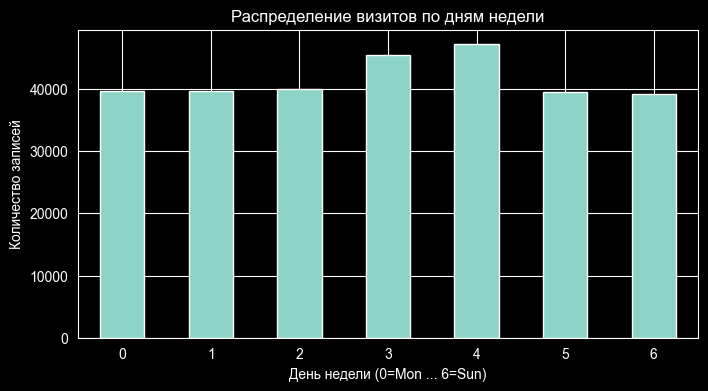

In [25]:
weekday_counts = df["weekday_num"].value_counts().sort_index()

plt.figure(figsize=(8,4))
weekday_counts.plot(kind="bar")

plt.xlabel("День недели (0=Mon ... 6=Sun)")
plt.ylabel("Количество записей")
plt.title("Распределение визитов по дням недели")
plt.xticks(rotation=0)
plt.show()

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290584 entries, 131228 to 193652
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       290584 non-null  int64         
 1   timestamp     290584 non-null  datetime64[ns]
 2   group         290584 non-null  object        
 3   landing_page  290584 non-null  object        
 4   converted     290584 non-null  int64         
 5   date          290584 non-null  object        
 6   hour          290584 non-null  int32         
 7   day           290584 non-null  int32         
 8   weekday_num   290584 non-null  int32         
dtypes: datetime64[ns](1), int32(3), int64(2), object(3)
memory usage: 18.8+ MB


In [27]:
df["timestamp"].describe()

count                           290584
mean     2025-01-13 13:42:03.906819584
min         2025-01-02 13:42:05.378582
25%      2025-01-08 02:06:43.829340672
50%      2025-01-13 13:21:45.577577728
75%      2025-01-19 01:49:46.966643968
max         2025-01-24 13:41:54.460509
Name: timestamp, dtype: object

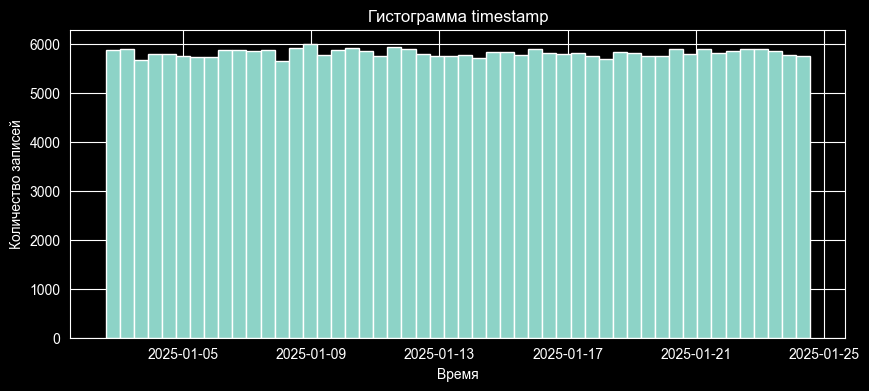

In [28]:
plt.figure(figsize=(10,4))
df["timestamp"].hist(bins=50)
plt.xlabel("Время")
plt.ylabel("Количество записей")
plt.title("Гистограмма timestamp")
plt.show()

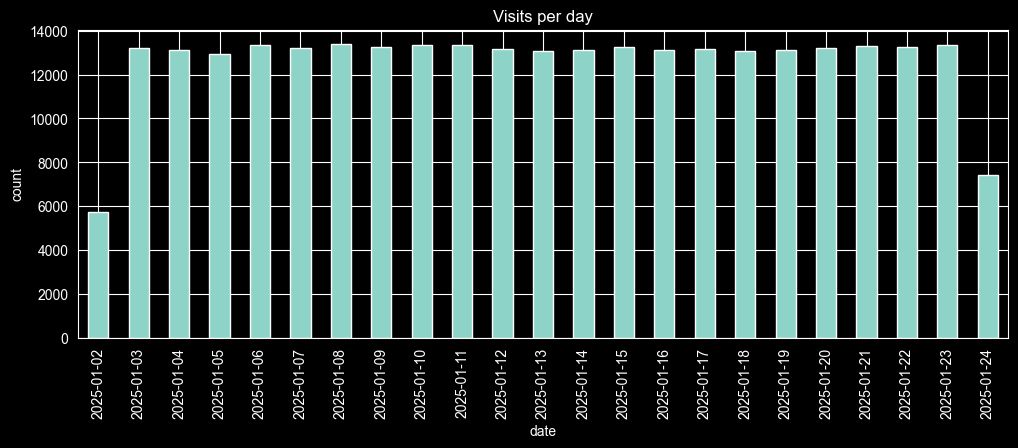

In [29]:
date_counts = df["date"].value_counts().sort_index()

date_counts.plot(kind="bar", figsize=(12,4))
plt.xlabel("date")
plt.ylabel("count")
plt.title("Visits per day")
plt.show()

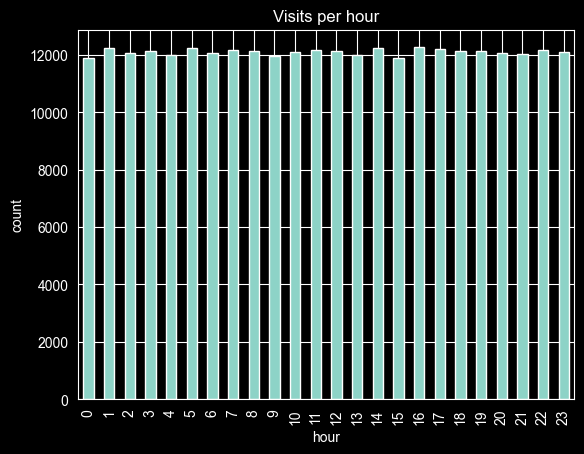

In [30]:
hour_counts = df["hour"].value_counts().sort_index()

hour_counts.plot(kind="bar")
plt.xlabel("hour")
plt.ylabel("count")
plt.title("Visits per hour")
plt.show()

время распределено в целом равномерно, нет никаких выбросов

#### group и landing_page

так как мы оставили, что каждой группе соответствует своя страница, то у них совпадают распределния

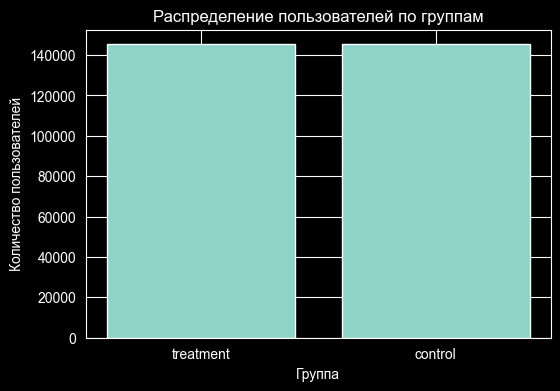

In [31]:
group_counts = df_clean["group"].value_counts()

plt.figure(figsize=(6,4))
plt.bar(group_counts.index, group_counts.values)

plt.xlabel("Группа")
plt.ylabel("Количество пользователей")
plt.title("Распределение пользователей по группам")

plt.show()

#### converted

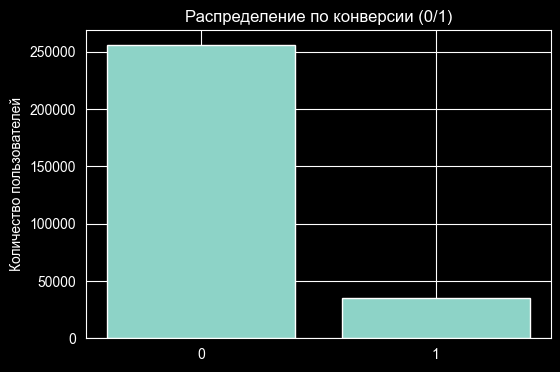

In [32]:
counts = df_clean["converted"].value_counts().sort_index()
labels = ["0", "1"]

plt.figure(figsize=(6,4))
plt.bar(labels, counts.values)

plt.ylabel("Количество пользователей")
plt.title("Распределение по конверсии (0/1)")
plt.show()

### fe

удалим ненужные столбцы

In [33]:
df = df.drop(columns=["user_id", "timestamp", "landing_page", "date"])
df.head()

,group,converted,hour,day,weekday_num
131228,treatment,0,13,2,3
184884,control,0,13,2,3
83878,control,0,13,2,3
102717,treatment,0,13,2,3
158789,treatment,0,13,2,3


особых зависимотсей не выявлено

## ВЫБОР МЕТРИКИ

Ключевая метрика - конверсия, потому что именно она отражает, что нам важно в этом A/B-тесте: какая доля пользователей совершила целевое действие. Все изменения в продукте оцениваются через изменение конверсии.

#### Связь метрики с другими признаками

In [34]:
df_conv1 = df[df["converted"] == 1]

In [35]:
df_conv1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34753 entries, 126997 to 260161
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   group        34753 non-null  object
 1   converted    34753 non-null  int64 
 2   hour         34753 non-null  int32 
 3   day          34753 non-null  int32 
 4   weekday_num  34753 non-null  int32 
dtypes: int32(3), int64(1), object(1)
memory usage: 1.2+ MB


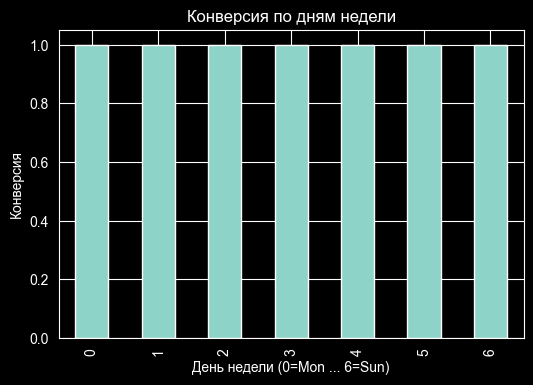

In [36]:
import matplotlib.pyplot as plt

conv_by_weekday = (
    df_conv1.groupby("weekday_num")["converted"]
      .mean()
      .sort_index()
)

plt.figure(figsize=(6,4))
conv_by_weekday.plot(kind="bar")
plt.xlabel("День недели (0=Mon ... 6=Sun)")
plt.ylabel("Конверсия")
plt.title("Конверсия по дням недели")
plt.show()

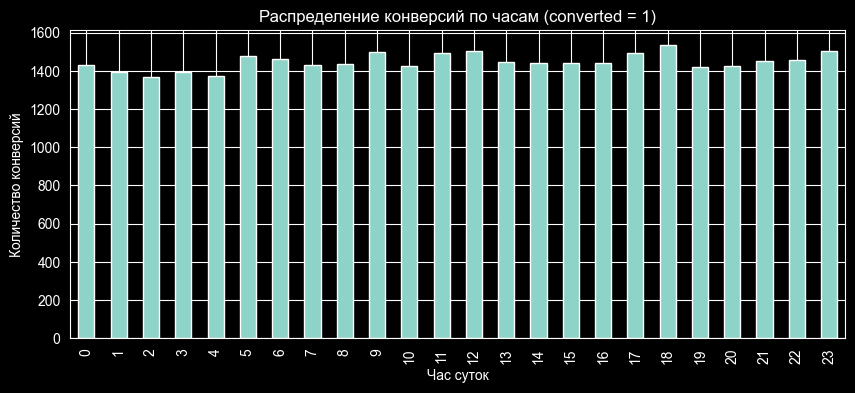

In [37]:
hour_counts = (
    df_conv1["hour"]
    .value_counts()
    .sort_index()
)

plt.figure(figsize=(10,4))
hour_counts.plot(kind="bar")
plt.xlabel("Час суток")
plt.ylabel("Количество конверсий")
plt.title("Распределение конверсий по часам (converted = 1)")
plt.show()

## КОРРЕКТНОСТЬ ПРОВЕДЕНИЯ ТЕСТИРОВАНИЯ

#### разбиваем на группы

In [38]:
gra = df[df["group"] == "control"]
grb = df[df["group"] == "treatment"]

In [39]:
gra = gra.drop(columns="group").reset_index(drop=True)
gra

,converted,hour,day,weekday_num
0,0,13,2,3
1,0,13,2,3
2,0,13,2,3
3,1,13,2,3
4,0,13,2,3
...,...,...,...,...
145269,1,13,24,4
145270,0,13,24,4
145271,0,13,24,4
145272,0,13,24,4


In [40]:
grb = grb.drop(columns="group").reset_index(drop=True)
grb

,converted,hour,day,weekday_num
0,0,13,2,3
1,0,13,2,3
2,0,13,2,3
3,0,13,2,3
4,0,13,2,3
...,...,...,...,...
145305,0,13,24,4
145306,0,13,24,4
145307,0,13,24,4
145308,0,13,24,4


In [41]:
print(len(gra))
print(len(grb))

145274
145310


#### однородность групп (распределения по признакам) (да)

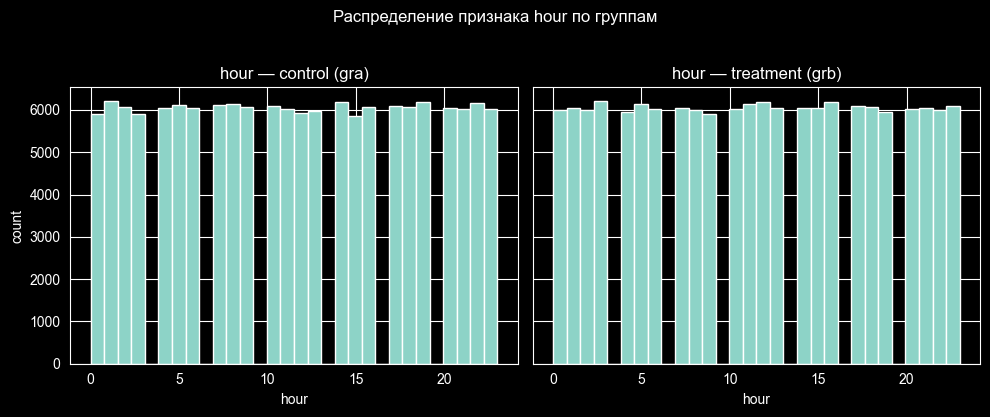

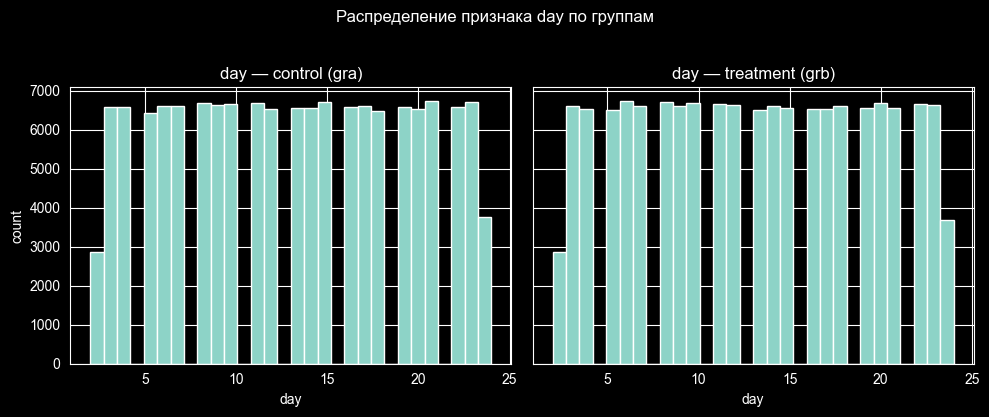

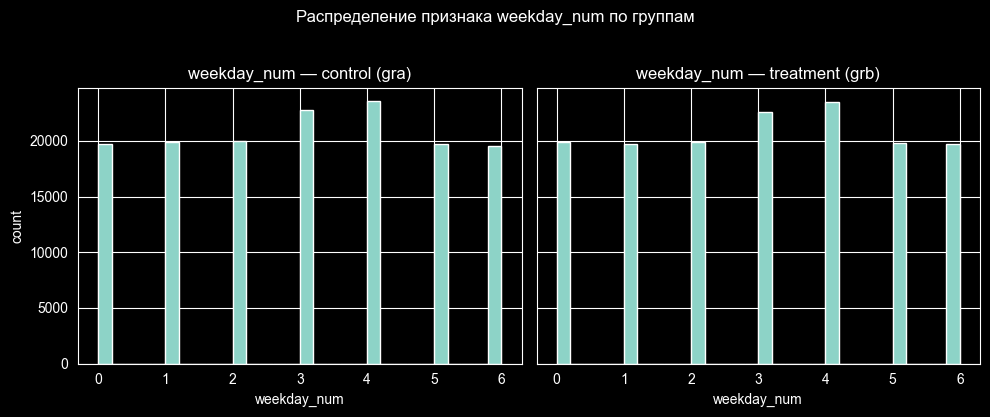

In [42]:
cols = ["hour", "day", "weekday_num"]

for col in cols:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    axes[0].hist(gra[col], bins=30)
    axes[0].set_title(f"{col} — control (gra)")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("count")

    axes[1].hist(grb[col], bins=30)
    axes[1].set_title(f"{col} — treatment (grb)")
    axes[1].set_xlabel(col)

    fig.suptitle(f"Распределение признака {col} по группам", y=1.03)
    plt.tight_layout()
    plt.show()

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290584 entries, 131228 to 193652
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   group        290584 non-null  object
 1   converted    290584 non-null  int64 
 2   hour         290584 non-null  int32 
 3   day          290584 non-null  int32 
 4   weekday_num  290584 non-null  int32 
dtypes: int32(3), int64(1), object(1)
memory usage: 10.0+ MB


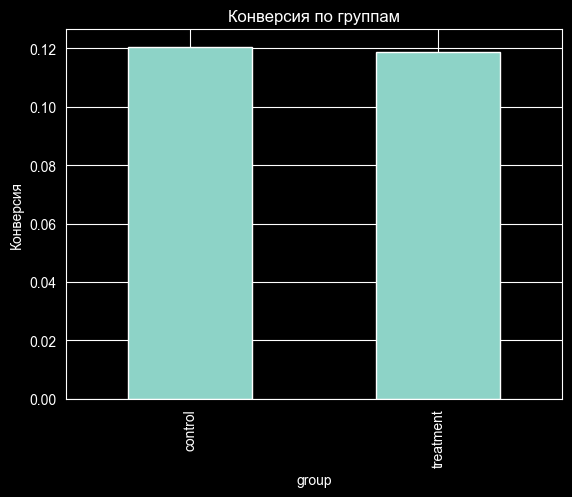

In [44]:
conv_by_group = df.groupby("group")["converted"].mean()

conv_by_group.plot(kind="bar")
plt.ylabel("Конверсия")
plt.title("Конверсия по группам")
plt.show()

группы по признакам однородны

#### сравнение связей метрики с параметрами по группам

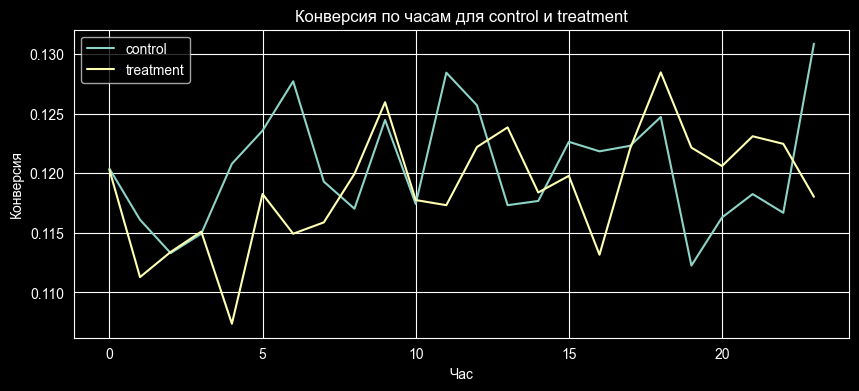

In [45]:
conv_hour_gra = gra.groupby("hour")["converted"].mean()
conv_hour_grb = grb.groupby("hour")["converted"].mean()

plt.figure(figsize=(10,4))
plt.plot(conv_hour_gra.index, conv_hour_gra.values, label="control")
plt.plot(conv_hour_grb.index, conv_hour_grb.values, label="treatment")
plt.xlabel("Час")
plt.ylabel("Конверсия")
plt.title("Конверсия по часам для control и treatment")
plt.legend()
plt.show()

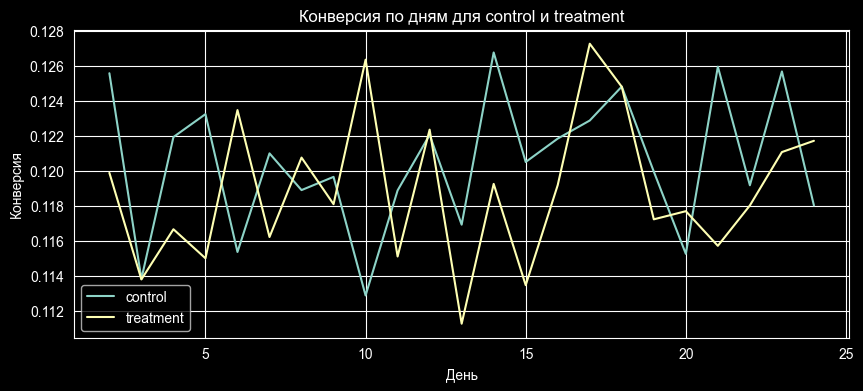

In [46]:
conv_hour_gra = gra.groupby("day")["converted"].mean()
conv_hour_grb = grb.groupby("day")["converted"].mean()

plt.figure(figsize=(10,4))
plt.plot(conv_hour_gra.index, conv_hour_gra.values, label="control")
plt.plot(conv_hour_grb.index, conv_hour_grb.values, label="treatment")
plt.xlabel("День")
plt.ylabel("Конверсия")
plt.title("Конверсия по дням для control и treatment")
plt.legend()
plt.show()

### AA тест (подтвердить что сплит система сработала хорошо)

но у нас уже проведем A/B тест так что надобноти в AA тесте нет

## ГИПОТЕЗЫ

H0 (нулевая гипотеза) - Средняя конверсия (доля пользователей, совершивших целевое действие) в контрольной и тестовой группе одинакова

H1 (альтернативная гипотеза) - Средняя конверсия в тестовой группе отличается от конверсии в контрольной группе.


# ПАРАМЕТРЫ КОТОРЫЕ ДОЛЖНЫ БЫТЬ ОПРЕДЕЛЕНЫ ЗАРАНЕЕ

**Уровень значимости (α) = 0,05**

Это вероятность ошибки первого рода - ситуации, когда мы ошибочно отвергаем нулевую гипотезу (то есть считаем, что есть эффект, хотя его нет)

**β = 0,2**

Это вероятность ошибки второго рода, то есть вероятность того, что мы не заметим эффект, даже если он на самом деле есть

**Мощность (1 − β) = 0,8**

Это вероятность обнаружить реальный эффект, если он действительно существует.


мощность показывает, с какой вероятностью тест правильно отвергнет нулевую гипотезу в ситуации, когда она неверна.

# СТАТИСТИЧЕСКИЙ ТЕСТ

метрика - бинарная (конверсия), поэтому используем X^2 тест

In [51]:
c_table = np.array([
    [
        (gra["converted"] == 0).sum(),
        (gra["converted"] == 1).sum(),
    ],
    [
        (grb["converted"] == 0).sum(),
        (grb["converted"] == 1).sum(),
    ]
])

print(c_table)

[[127785  17489]
 [128046  17264]]


In [52]:
from scipy.stats import chi2_contingency

chi2_contingency(c_table)

Chi2ContingencyResult(statistic=np.float64(1.7035660051885058), pvalue=np.float64(0.19182228096235665), dof=1, expected_freq=array([[127899.65274757,  17374.34725243],
       [127931.34725243,  17378.65274757]]))

У нас нет оснований отвергнуть нулевую гипотезу (pvalue = 0.2 > 0.05)

Статистически значимой разницы конверсии между control и treatment по данным этого эксперимента не обнаружено

# Bootstrap


Ранее сравнение конверсий между группами проводилось с использованием статистических тестов. Далее для более детального анализа эффекта и оценки возможного диапазона значений разницы конверсий применим алгоритм bootstrap:

In [53]:
b = 2000
d = []

for i in range(b):
    c = gra.sample(frac=1, replace=True)
    t = grb.sample(frac=1, replace=True)

    pc = c['converted'].mean()
    pt = t['converted'].mean()

    d.append(pt - pc)

d = np.array(d)

eff = grb['converted'].mean() - gra['converted'].mean()

lo, hi = np.percentile(d, [2.5, 97.5])

print(f'Насколько отличаются конверсии: {eff}')
print(f'Границы 95% доверительного интервала: [{lo}, {hi}]')


Насколько отличаются конверсии: -0.0015782389853555567
Границы 95% доверительного интервала: [-0.0038992450595236113, 0.000858533503405275]


Можно заметить, что статистически значимого эффекта разности конверсий между контрольной и экспериментальной группами нет. Оценка разницы конверсий составляет -0.00277, то есть в группе treatment конверсия немного ниже. Однако 95% доверительный интервал для разности конверсий равен [−0.00941; 0.00383] и содержит ноль, что говорит об отсутствии статистически значимых различий между группами.

Рассмотрим визуально:



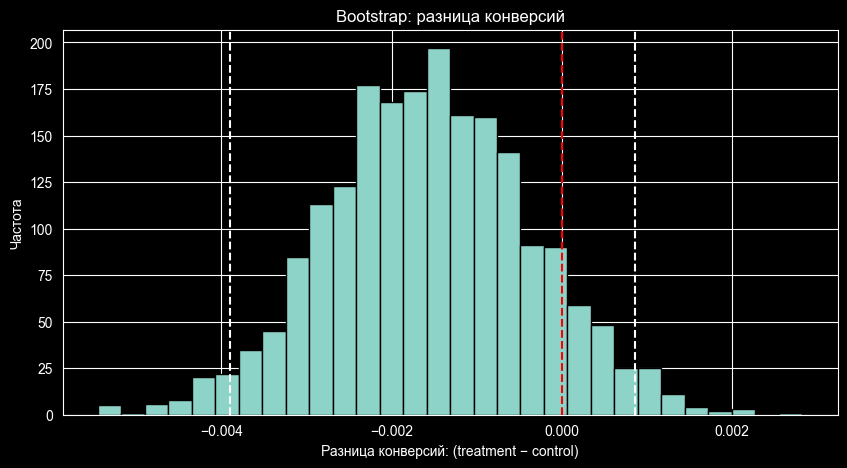

In [54]:
plt.figure(figsize=(10,5))
plt.hist(d, bins=30, edgecolor = 'black')
plt.axvline(0, linestyle = '--', color = 'red')  #нет эффекта - 0
plt.axvline(lo, linestyle = '--') #перцентили
plt.axvline(hi, linestyle = '--')
plt.xlabel('Разница конверсий: (treatment − control)')
plt.ylabel('Частота')
plt.title('Bootstrap: разница конверсий')
plt.show()


На графике визуально видно, что ноль находится внутри основной массы распределения, что показывает, что данные и правда допускают ситуацию, где разница конверсий равна нулю, несмотря на то, что чаще всего разница отрицательная (так как центр лежит левее нуля).

**Вывод:**

Визуальный анализ bootstrap-распределения разницы конверсий подтверждает результаты теста: значение 0 не лежит в хвосте распределения, а значит, статистически значимого отличия между группами не обнаружено.

# Анализ чувствительности (Sensitivity analysis)

Для проверки устойчивости полученного вывода проведем анализ чувствительности, в рамках которого сравнение конверсий выполним на различных долях исходной выборки  (от 20% до 100%).

In [55]:
s = np.linspace(0.2, 1.0, 10)
p = []

for x in s:
    n1 = int(len(gra) * x)
    n2 = int(len(grb) * x)

    a = gra.sample(n=n1)
    b = grb.sample(n=n2)

    y1 = a["converted"].sum()
    y2 = b["converted"].sum()

    t = [[y1, n1 - y1],
         [y2, n2 - y2]]

    i, pv, i, i = chi2_contingency(t)
    p.append(pv)

p



[np.float64(0.4909007186929363),
 np.float64(0.3207247310117074),
 np.float64(0.03064952193521368),
 np.float64(0.3278904754967495),
 np.float64(0.08415207429451532),
 np.float64(0.3002448452620988),
 np.float64(0.1537062424162173),
 np.float64(0.33036956531565764),
 np.float64(0.5617220545943602),
 np.float64(0.1918222809623566)]

Все полученные pi-value оказались выше уровня значимости - 0,05, то есть никакой размер выборки не выявляет статистически значимые различия. То есть объем данных никак не может повлиять на результат, поэтому он остается устойчивым.

In [59]:
res = pd.DataFrame({'Доля выборки': s, 'p-value': p})
res



,Доля выборки,p-value
0,0.200000,0.490901
1,0.288889,0.320725
2,0.377778,0.030650
3,0.466667,0.327890
4,0.555556,0.084152
5,0.644444,0.300245
6,0.733333,0.153706
7,0.822222,0.330370
8,0.911111,0.561722
9,1.000000,0.191822


Рассмотрим визуально:

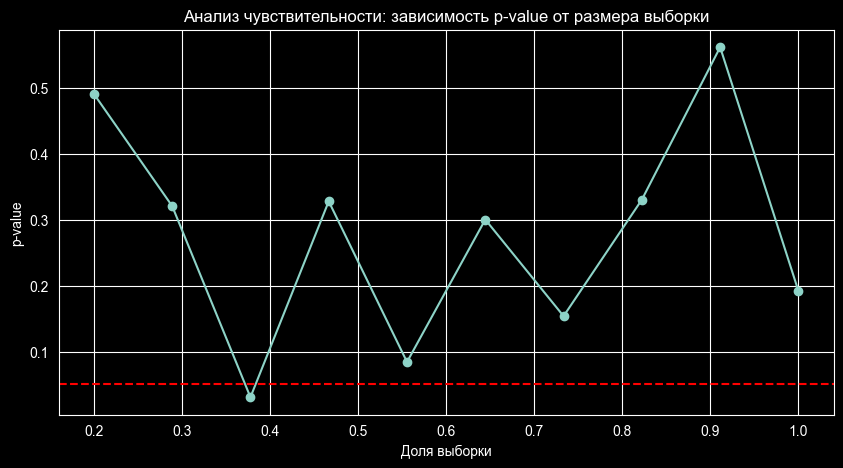

In [60]:
plt.figure(figsize=(10, 5))

plt.plot(s, p, marker='o')
plt.axhline(0.05, linestyle='--', color = 'red')

plt.title('Анализ чувствительности: зависимость p-value от размера выборки')
plt.xlabel('Доля выборки')
plt.ylabel('p-value')

plt.show()


На графике видно, что значения p-value изменяются при увеличении доли выборки, однако ни в одном случае не опускаются ниже уровня значимости 0.05. Если бы эффект реально существовал на графике была бы другая ситуация: p-value уменьшалось бы по мере роста выборки и устойчиво опускалось бы ниже 0.05, но такой ситуации заметно нет.

Полученные анализом чувствительности результаты подтверждают устойчивость вывода и позволяют заключить, что статистически значимого эффекта между контрольной и экспериментальной группами не обнаружено, они действительно одинаковы, поэтому результат А/B теста можно считать надежным, применение bootstrap и анализа чувсвительности это доказали.

